In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import numpy as np
import my_functions as my
import gsw
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import pandas as pd
import glidertools as gt
import my_plot_params

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=3)

yearsFmt = mdates.DateFormatter("%d/%m")

mnthFmt = mdates.DateFormatter("%B")

lightblue = '#5499c7'
blue      = '#21618c'
orange    = '#f39c12'
green     = '#27ae60'
red       = '#cb4335'

In [2]:
dat_saz = xr.open_dataset('../data/dat_saz_6H.nc')
dat_pfz = xr.open_dataset('../data/dat_pfz_6H.nc')
dat_miz = xr.open_dataset('../data/dat_miz_6H.nc')

In [3]:
import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

for dat in [dat_saz, dat_pfz, dat_miz]:
    
    dat['dayofyear']=mdates.date2num(dat.time)-day0

In [4]:
for dat in [dat_saz, dat_pfz, dat_miz]:

    xt=[]
    xs=[]
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        xt += dat.temp.sel(depth=slice(5, m)).mean(dim='depth').values[i],
        xs += dat.salt.sel(depth=slice(5, m)).mean(dim='depth').values[i],
    
    dat['ml_s'] = (('time'), xs)
    dat['ml_t'] = (('time'), xt)
    
    dat['ml_s_smooth'] = (('time'), gt.cleaning.rolling_window(dat['ml_s'], func=np.nanmean, window=6).data)
    dat['ml_t_smooth'] = (('time'), gt.cleaning.rolling_window(dat['ml_t'], func=np.nanmean, window=6).data)

### Mixed layer equations

In [5]:
import ml_budget as mlb 

In [6]:
dat_miz['dT_grad'] = dat_miz['dT_grad'].ffill(dim='time').bfill(dim='time')
dat_miz['dS_grad'] = dat_miz['dS_grad'].ffill(dim='time').bfill(dim='time')

In [7]:
for dat in [dat_saz, dat_pfz, dat_miz]:
    
    dat['ml_s_smooth'] = dat['ml_s_smooth'].bfill(dim='time').ffill(dim='time')
    dat['ml_t_smooth'] = dat['ml_t_smooth'].bfill(dim='time').ffill(dim='time')
    
    Q   = dat['qnet']
    mld = dat['mld_03']      
    E   = dat['e']   
    P   = dat['tp']  
    S   = dat['ml_s_smooth']        
  
    # surface fluxes
    dat['dT_hf']    = mlb.heatflux(Q=Q, mld=mld)      
    dat['dS_ff']    = mlb.freshwaterflux(E=E, P=P, mld=mld, S=S)
            
    dat = mlb.entrainment(dat=dat, mld=dat['mld_03'], xld=dat['xld_est'], dt=21600)
            

# ekman transport
dat_saz = mlb.ekman_transport(dat_saz, dt=86400, grad='tsg')
dat_pfz = mlb.ekman_transport(dat_pfz, dt=86400, grad='tsg')
dat_miz = mlb.ekman_transport(dat_miz, dt=86400, grad='grad')

In [8]:
dat_saz_1D = dat_saz.resample(time='1D', loffset='12H').mean()
dat_pfz_1D = dat_pfz.resample(time='1D', loffset='12H').mean()
dat_miz_1D = dat_miz.resample(time='1D', loffset='12H').mean()

In [9]:
for dat in [dat_saz_1D, dat_pfz_1D, dat_miz_1D]:
    
    dat['dayofyear']=mdates.date2num(dat.time)-day0

In [10]:
plt.rc('ytick.major', size=4)
plt.rc('xtick.major', size=4)

In [11]:
from matplotlib.ticker import MultipleLocator

majorLocator = MultipleLocator(10)
minorLocator = MultipleLocator(5)

### Temperature tendency Figure 7

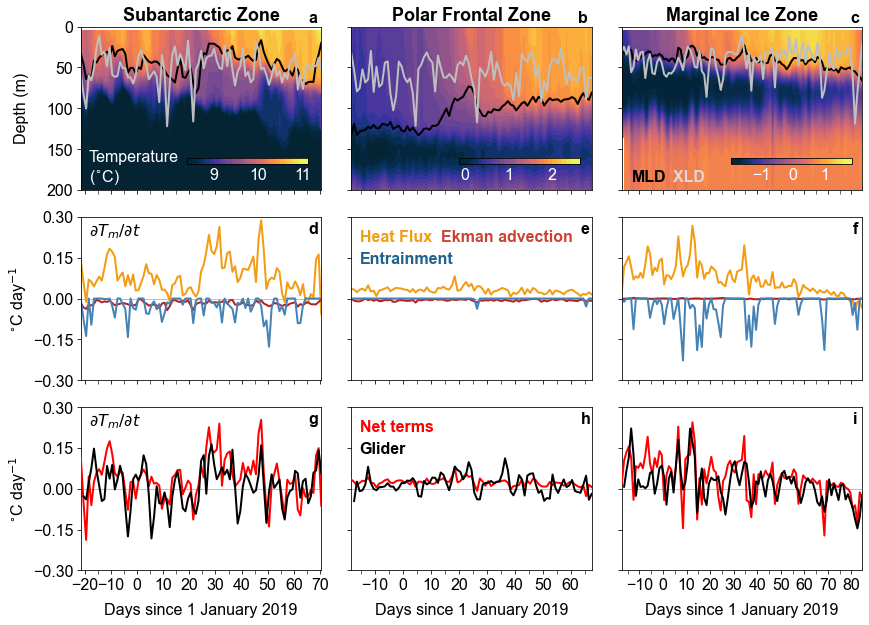

In [25]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(nrows=9,ncols=3) 
fig.subplots_adjust(hspace=0.75, wspace=0.125)

for i, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):

    # plotting the mixed layer sections
    
    ax1 = fig.add_subplot(gs[0:3, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    vmins = [8.5,0, -1.8]
    vmaxs = [11, 2.5, 1.7]
    
    h1=ax1.contourf(dat.dayofyear.values, dat.depth, dat.temp.T, levels=np.arange(vmins[i], vmaxs[i]+0.1, 0.1), cmap=cmo.thermal, extend='both')
    
    ax1.plot(dat.dayofyear, dat.mld_03 , c='k',    lw=2)
    ax1.plot(dat.dayofyear, dat.xld_est, c='0.75', lw=2)
    
    ax1.xaxis.set_ticklabels([])
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax2 = fig.add_subplot(gs[3:6, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    dat['hf_dT'] = dat['dT_hf']      *86400
    dat['ek_dT'] = dat['ek_trans_dT']*86400
    dat['en_dT'] = dat['ent_dT']     *86400
    
    
    ax2.plot(dat.dayofyear, dat['hf_dT'], c=orange,      label='Heat flux')
    ax2.plot(dat.dayofyear, dat['ek_dT'], c='firebrick', label='Ekman advection')
    ax2.plot(dat.dayofyear, dat['en_dT'], c='steelblue', label='Entrainment')
    
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax3 = fig.add_subplot(gs[6:9, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)        

    dat['net_terms_dT'] = dat['hf_dT'] + dat['ek_dT'] + dat['en_dT'] 
    dat['glider_dT']    = dat['ml_t_smooth'].diff(dim='time')
    
    ax3.plot(dat.dayofyear    , dat['net_terms_dT']    , label='Net terms', c='r', zorder=10) 
    ax3.plot(dat.dayofyear[1:], dat['glider_dT'][1:],    label='Glider',    c='k', zorder=10)     
    

    ################################
    # plotting edits
    ################################
    
    if i==0:
        ax1.set_ylabel('Depth (m)', labelpad=18)
        ax2.set_ylabel('$^{\circ}$C day$^{-1}$')
        ax3.set_ylabel('$^{\circ}$C day$^{-1}$')
        
    if i>0:
        for a in [ax1, ax2, ax3]:
            a.yaxis.set_ticklabels([])

    for a in [ax1, ax2, ax3]:
        
        a.xaxis.set_major_locator(majorLocator)
        a.xaxis.set_minor_locator(minorLocator)
                
    ax1.set_xlim(dat.dayofyear.values[0], dat.dayofyear.values[-1])
    ax2.set_xlim(dat.dayofyear.values[0], dat.dayofyear.values[-1])
    ax3.set_xlim(dat.dayofyear.values[0], dat.dayofyear.values[-1])

    ax1.set_ylim(200, 0)
    ax1.yaxis.set_ticks([0, 50, 100, 150,  200])

    
    # colorbars 
    
    if i==0:
        cax = fig.add_axes(([0.23, 0.69, 0.12, 0.0075]))
        cb = plt.colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb.ax.tick_params(length=0)
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    if i==1:
        cax = fig.add_axes(([0.50, 0.69, 0.12, 0.0075]))
        cb = plt.colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb.ax.tick_params(length=0)
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    if i==2:
        cax = fig.add_axes(([0.77, 0.69, 0.12, 0.0075]))
        cb = plt.colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb.ax.tick_params(length=0)
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
        
    ax2.set_ylim(-0.3, 0.3)
    ax3.set_ylim(-0.3, 0.3)
    
    ax2.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    ax3.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    
    ax2.plot([-22, 85], [0, 0], zorder=0, lw=1, c='0.75')
    ax3.plot([-22, 85], [0, 0], zorder=0, lw=1, c='0.75')

    ax1.xaxis.set_ticklabels([])
    ax2.xaxis.set_ticklabels([])
        
    if i==0:
        ax2.text(dat.dayofyear[3], 0.23, r'$\partial T_m / \partial t$')
        ax3.text(dat.dayofyear[3], 0.23, r'$\partial T_m / \partial t$')
        ax1.text(dat.dayofyear[3], 165, 'Temperature', c='w')
        ax1.text(dat.dayofyear[3], 190, '($^{\circ}$C)', c='w')
        
        ax1.text(dat.dayofyear[-6], -5,   'a', fontweight='bold')
        ax2.text(dat.dayofyear[-6], 0.24, 'd', fontweight='bold')
        ax3.text(dat.dayofyear[-6], 0.24, 'g', fontweight='bold')
        
        ax1.set_title('Subantarctic Zone',  fontsize=18, fontweight='bold')
        
        ax3.set_xlabel('Days since 1 January 2019', labelpad=10)
        
    if i==1:
        ax2.text(dat.dayofyear[3], 0.21, 'Heat Flux',       c=orange, fontweight='bold')
        ax2.text(dat.dayofyear[3], 0.13, 'Entrainment',     c=blue,   fontweight='bold')
        ax2.text(dat.dayofyear[32],0.21, 'Ekman advection', c=red,    fontweight='bold')
        
        ax3.text(dat.dayofyear[3], 0.21, 'Net terms', c='r', fontweight='bold')
        ax3.text(dat.dayofyear[3], 0.13, 'Glider', c='k', fontweight='bold')
        
        ax1.text(dat.dayofyear[-6], -5,   'b', fontweight='bold')
        ax2.text(dat.dayofyear[-5], 0.24, 'e', fontweight='bold')
        ax3.text(dat.dayofyear[-5], 0.24, 'h', fontweight='bold')
        
        ax1.set_title('Polar Frontal Zone', fontsize=18, fontweight='bold')
        
        ax3.set_xlabel('Days since 1 January 2019', labelpad=10)
        
    if i==2:
        ax1.text(dat_miz.dayofyear[15], 190,  'MLD', c='k',   fontweight='bold', zorder=100)
        ax1.text(dat_miz.dayofyear[85], 190, 'XLD', c='0.85', fontweight='bold', zorder=100)
        
        ax1.text(dat.dayofyear[-6], -5,   'c', fontweight='bold')
        ax2.text(dat.dayofyear[-5], 0.24, 'f', fontweight='bold')
        ax3.text(dat.dayofyear[-5], 0.24, 'i', fontweight='bold')
        
        ax1.set_title('Marginal Ice Zone',  fontsize=18, fontweight='bold')
        
        ax3.set_xlabel('Days since 1 January 2019', labelpad=10)


plt.savefig('../figs_submission3/fig7.png', dpi=300, bbox_inches='tight')

### Salinity tendency Figure 8

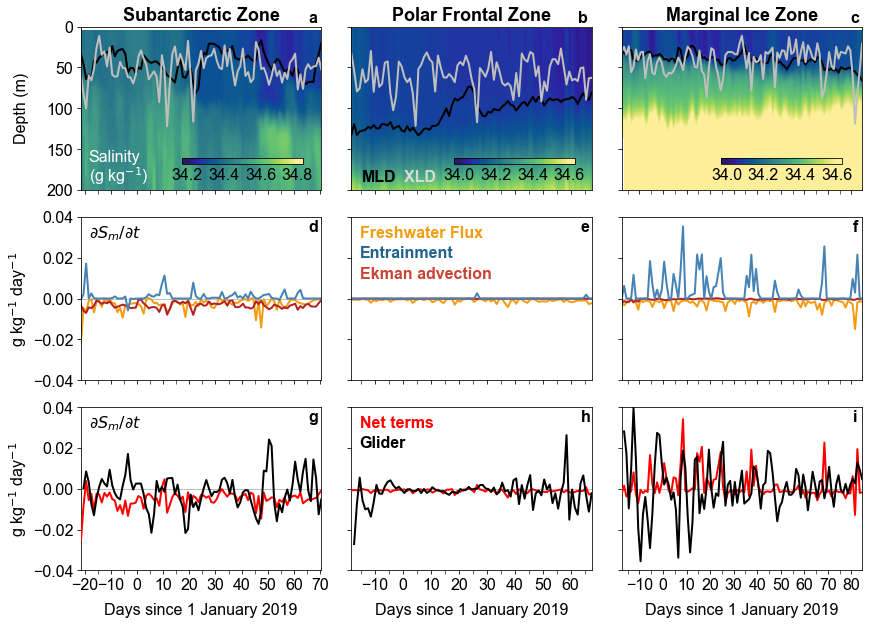

In [24]:
# set the plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(nrows=9,ncols=3) 
fig.subplots_adjust(hspace=0.75, wspace=0.125)

for i, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):

    # plotting the mixed layer sections
    
    ax1 = fig.add_subplot(gs[0:3, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    vmins = [34.2, 34, 34]
    vmaxs = [34.8, 34.6, 34.6]
    
    h1=ax1.contourf(dat.dayofyear.values, dat.depth, dat.salt.T, levels=np.arange(vmins[i], vmaxs[i]+0.01, 0.01), cmap=cmo.haline, extend='both')
    
    ax1.plot(dat.dayofyear, dat.mld_03 , c='k',    lw=2)
    ax1.plot(dat.dayofyear, dat.xld_est, c='0.75', lw=2)
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax2 = fig.add_subplot(gs[3:6, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)

    dat['ff_dS'] = dat['dS_ff']       *86400
    dat['ek_dS'] = dat['ek_trans_dS'] *86400
    dat['en_dS'] = dat['ent_dS']      *86400
  
    ax2.plot(dat.dayofyear, dat['ff_dS'], c=orange,        lw=2, label='Freshwater flux')
    ax2.plot(dat.dayofyear, dat['ek_dS'], c='firebrick',   lw=2, label='Ekman advection')
    ax2.plot(dat.dayofyear, dat['en_dS'], c='steelblue',   lw=2, label='Entrainment')
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax3 = fig.add_subplot(gs[6:9, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)        

    dat['net_terms_dS'] = dat['ff_dS'] + dat['ek_dS'] + dat['en_dS'] 
    dat['glider_dS']    = dat['ml_s_smooth'].diff(dim='time')
    
    ax3.plot(dat.dayofyear    , dat['net_terms_dS'], label='Net terms',  c='r', lw=2, zorder=10) 
    ax3.plot(dat.dayofyear[1:], dat['glider_dS'][1:], label='Glider',    c='k', lw=2, zorder=10)        
        
    ################################
    # plotting edits
    ################################
    
    if i==0:
        ax1.set_ylabel('Depth (m)', labelpad=18)
        ax2.set_ylabel( 'g kg$^{-1}$ day$^{-1}$')
        ax3.set_ylabel( 'g kg$^{-1}$ day$^{-1}$')
        
    if i>0:
        for a in [ax1, ax2, ax3]:
            a.yaxis.set_ticklabels([])

    for a in [ax1, ax2, ax3]:
        
        a.xaxis.set_major_locator(majorLocator)
        a.xaxis.set_minor_locator(minorLocator)
                
    ax1.set_xlim(dat.dayofyear.values[0], dat.dayofyear.values[-1])
    ax2.set_xlim(dat.dayofyear.values[0], dat.dayofyear.values[-1])
    ax3.set_xlim(dat.dayofyear.values[0], dat.dayofyear.values[-1])
        
    ax1.yaxis.set_ticks([0, 50, 100, 150, 200])
    
    ax1.xaxis.set_ticklabels([])
    ax2.xaxis.set_ticklabels([])        
    
    # colorbars 
    
    if i==0:
        cax = fig.add_axes(([0.225, 0.69, 0.12, 0.0075]))
        cb = plt.colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        cb.ax.tick_params(length=0)
        
    if i==1:
        cax = fig.add_axes(([0.495, 0.69, 0.12, 0.0075]))
        cb = plt.colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        cb.ax.tick_params(length=0)
        
    if i==2:
        cax = fig.add_axes(([0.76, 0.69, 0.12, 0.0075]))
        cb = plt.colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        cb.ax.tick_params(length=0)
        
    ax2.set_ylim(-0.04, 0.04)
    ax3.set_ylim(-0.04, 0.04)
    
    ax2.plot([-22, 85], [0, 0], zorder=0, lw=1, c='0.75')
    ax3.plot([-22, 85], [0, 0], zorder=0, lw=1, c='0.75')
    
    ax1.set_ylim(200, 0)
    
    if i==0:
        ax2.text(dat.dayofyear[3], 0.03, r'$\partial S_m / \partial t$')
        ax3.text(dat.dayofyear[3], 0.03, r'$\partial S_m / \partial t$')
        ax1.text(dat.dayofyear[3], 165, 'Salinity', c='w')
        ax1.text(dat.dayofyear[3], 190, '(g kg$^{-1}$)', c='w')
        
        ax1.text(dat.dayofyear[-6], -5,    'a', fontweight='bold')
        ax2.text(dat.dayofyear[-6], 0.033, 'd', fontweight='bold')
        ax3.text(dat.dayofyear[-6], 0.033, 'g', fontweight='bold')
        
        ax1.set_title('Subantarctic Zone',  fontsize=18, fontweight='bold')
        
        ax3.set_xlabel('Days since 1 January 2019', labelpad=10)
        
    if i==1:
        ax2.text(dat.dayofyear[3], 0.03, 'Freshwater Flux',       c=orange, fontweight='bold')
        ax2.text(dat.dayofyear[3], 0.02, 'Entrainment',     c=blue,   fontweight='bold')
        ax2.text(dat.dayofyear[3],0.01, 'Ekman advection', c=red,    fontweight='bold')
        
        ax3.text(dat.dayofyear[3], 0.03, 'Net terms', c='r', fontweight='bold')
        ax3.text(dat.dayofyear[3], 0.02, 'Glider', c='k', fontweight='bold')
        
        ax1.text(dat.dayofyear[-6], -5,    'b', fontweight='bold')
        ax2.text(dat.dayofyear[-5], 0.033, 'e', fontweight='bold')
        ax3.text(dat.dayofyear[-5], 0.033, 'h', fontweight='bold')
        
        ax1.set_title('Polar Frontal Zone', fontsize=18, fontweight='bold')
        ax1.text(dat_pfz.dayofyear[15], 190,  'MLD', c='k',   fontweight='bold', zorder=100)
        ax1.text(dat_pfz.dayofyear[75], 190, 'XLD', c='0.85', fontweight='bold', zorder=100)
        
        ax3.set_xlabel('Days since 1 January 2019', labelpad=10)
        
    if i==2:
        
        ax1.text(dat.dayofyear[-6], -5,    'c', fontweight='bold')
        ax2.text(dat.dayofyear[-5], 0.033, 'f', fontweight='bold')
        ax3.text(dat.dayofyear[-5], 0.033, 'i', fontweight='bold')
        
        ax1.set_title('Marginal Ice Zone',  fontsize=18, fontweight='bold')
        
        ax3.set_xlabel('Days since 1 January 2019', labelpad=10)

plt.savefig('../figs_submission3/fig8.png', dpi=300, bbox_inches='tight')

In [16]:
dat_saz_1D.to_netcdf('../dat_saz_1D.nc')
dat_pfz_1D.to_netcdf('../dat_pfz_1D.nc')
dat_miz_1D.to_netcdf('../dat_miz_1D.nc')

In [ ]:
dat_saz.to_netcdf('../dat_saz_6H.nc')
dat_pfz.to_netcdf('../dat_pfz_6H.nc')
dat_miz.to_netcdf('../dat_miz_6H.nc')